In [0]:
# Import support libraries
import cv2
import json
import math
import os
from PIL import Image
from zipfile import ZipFile

# Import libraries for scientific computing and plotting 
import math
import scipy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Import TensorFlow, Keras, Sklearn
import tensorflow as tf
from keras import layers
from keras.applications import DenseNet121
from keras.callbacks import Callback, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

# Print out some versions
print(tf.__version__)
print(np.__version__)
print(pd.__version__)
print ()
# Print out list of input files
print(os.listdir("../aptos2019-blindness-detection"))

%matplotlib inline


Using TensorFlow backend.


2.0.0
1.17.3
0.25.3

['test_images', 'test_images.zip', 'train.csv', 'sample_submission.csv', 'Untitled.ipynb', '.ipynb_checkpoints', 'train_images', 'test.csv', 'Untitled1.ipynb']


# STEP 2 : 
Import, Visualize and Pre-process data


(3662, 2)
(1928, 1)
           id_code
0     0005cfc8afb6
1     003f0afdcd15
2     006efc72b638
3     00836aaacf06
4     009245722fa4
...            ...
1923  ff2fd94448de
1924  ff4c945d9b17
1925  ff64897ac0d8
1926  ffa73465b705
1927  ffdc2152d455

[1928 rows x 1 columns]


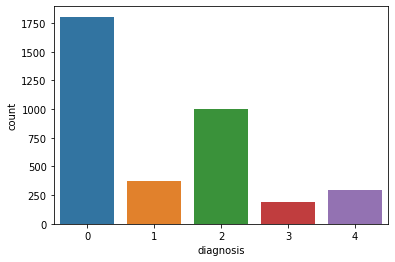

In [0]:
# Import csv file (train and test) and print shape of inputs
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

print (train_data.shape)
print (test_data.shape)
print (test_data)

train_ID = train_data['id_code']
train_diagnosis = train_data['diagnosis']

# Print number of values with each diagnosis code
train_diagnosis.value_counts()

# Plot barplot for diagnosis codes
p = sns.countplot(data=train_data, x = train_data['diagnosis'])

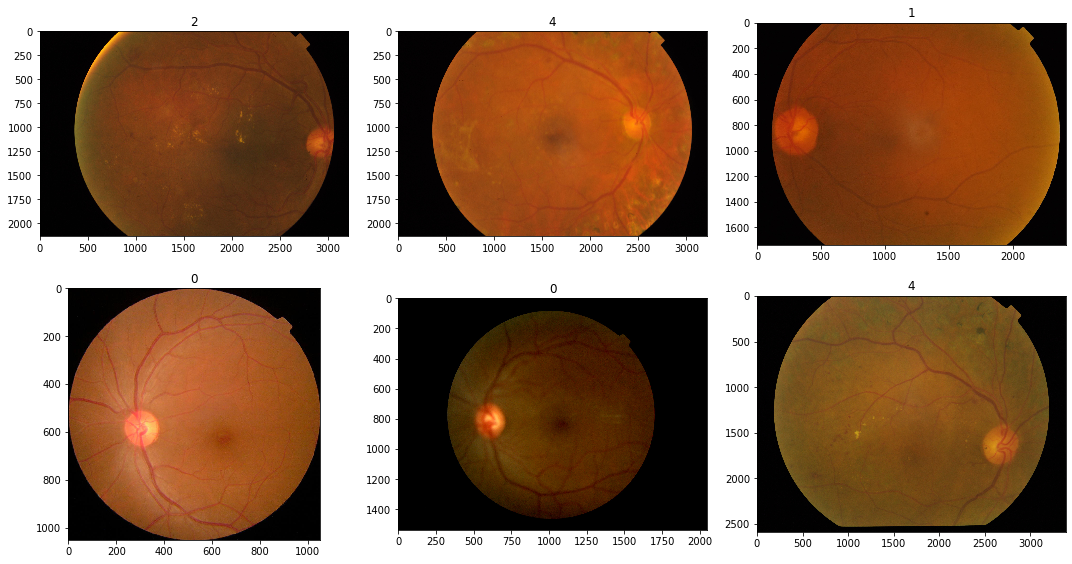

In [0]:
# Functions

## Function to view images
def view_images(data, columns=3, rows=2):
    
    fig = plt.figure(figsize=(5*columns, 4*rows))

    for i in range(columns*rows):
        image_path = data.loc[i,'id_code']
        image_id = data.loc[i,'diagnosis']
        img = cv2.imread(f'train_images/{image_path}.png')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        fig.add_subplot(rows, columns, i+1)
        plt.title(image_id)
        plt.imshow(img)
    
    plt.tight_layout()

## Function to pre-process the images
def preprocess_image(image_path, desired_size=224):
    im = cv2.imread(image_path)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    im = cv2.resize(im, (desired_size,desired_size))
    im = cv2.addWeighted(im,4,cv2.GaussianBlur(im, (0,0), desired_size/30) ,-4 ,128)
    return im
view_images(train_data)


# Resize Images
We will resize the images to 224x224, then create a single numpy array to hold the data.

In [0]:
N = train_data.shape[0]
x_train = np.empty((N, 224, 224, 3), dtype=np.uint8)

for i, image_id in enumerate(tqdm(train_data['id_code'])):
    x_train[i, :, :, :] = preprocess_image(f'train_images/{image_id}.png')

100%|██████████| 3662/3662 [10:25<00:00,  5.85it/s]


In [0]:
N = test_data.shape[0]
x_test = np.empty((N, 224, 224, 3), dtype=np.uint8)

for i, image_id in enumerate(tqdm(test_data['id_code'])):
    x_test[i, :, :, :] = preprocess_image(f'test_images/{image_id}.png')

100%|██████████| 1928/1928 [02:39<00:00, 12.12it/s]


In [0]:
y_train = pd.get_dummies(train_data['diagnosis']).values
y_train_single = train_data['diagnosis']
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)

(3662, 224, 224, 3)
(3662, 5)
(1928, 224, 224, 3)


# Step 3:
Define Model

In [0]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='elu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='elu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='elu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='elu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='elu'),
    tf.keras.layers.Dense(5, activation='softmax')
])

In [0]:
model.compile(optimizer='adam', 
              loss='categorical_crossentropy',
              metrics=['mae', 'accuracy'])

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 128)       1

In [0]:
EPOCHS = 10
BATCH_SIZE = 32 

print (x_train.shape)
print (y_train.shape)

history = model.fit(x=x_train, y=y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, 
                       verbose=1, callbacks=None, validation_split=0.10, validation_data=None, 
                    shuffle=True)

(3662, 224, 224, 3)
(3662, 5)
Train on 3295 samples, validate on 367 samples
Epoch 1/10
3295/3295 [==============================] - 299s 91ms/sample - loss: 18.0810 - mae: 0.1990 - accuracy: 0.5347 - val_loss: 1.4807 - val_mae: 0.2509 - val_accuracy: 0.5014
Epoch 2/10
3295/3295 [==============================] - 487s 148ms/sample - loss: 1.1075 - mae: 0.1654 - accuracy: 0.6355 - val_loss: 0.8849 - val_mae: 0.1411 - val_accuracy: 0.6894
Epoch 3/10
3295/3295 [==============================] - 236s 72ms/sample - loss: 0.9496 - mae: 0.1535 - accuracy: 0.6753 - val_loss: 1.2237 - val_mae: 0.2097 - val_accuracy: 0.6213
Epoch 4/10
3295/3295 [==============================] - 233s 71ms/sample - loss: 1.0208 - mae: 0.1521 - accuracy: 0.6765 - val_loss: 0.8701 - val_mae: 0.1304 - val_accuracy: 0.7166
Epoch 5/10
3295/3295 [==============================] - 257s 78ms/sample - loss: 0.9642 - mae: 0.1473 - accuracy: 0.6926 - val_loss: 0.8188 - val_mae: 0.1430 - val_accuracy: 0.7003
Epoch 6/10
3295/

Example

In [0]:
true_labels = np.array([1, 0, 1, 1, 0, 1])
pred_labels = np.array([1, 0, 0, 0, 0, 1])

In [0]:
accuracy_score(true_labels, pred_labels)

0.6666666666666666

In [0]:
cohen_kappa_score(true_labels, pred_labels)

0.3999999999999999

Creating keras callback for QWK

# Define IoU metric

In [0]:

def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

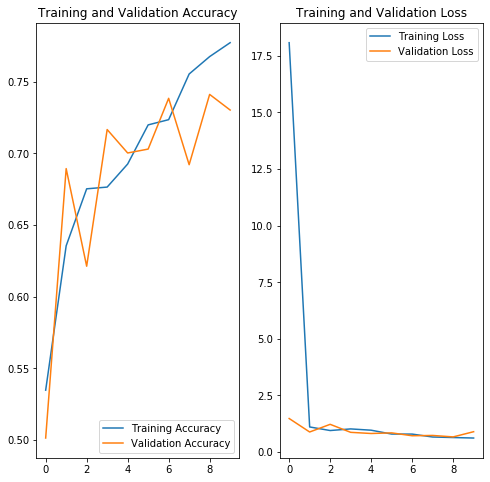

In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('./foo.png')
plt.show()